

> Tambahkan blockquote



In [47]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Membuat model untuk sistem rekomendasi


# **Membuat desain model CNN untuk klasifikasi jenis - jenis tanah**

 kami mengambil dataset tanah dari [kagle](https://www.kaggle.com/datasets/fuadkahfi/dataset-tanah), kita mendapat 8 sampel jenis tanah dan total 880 datasets

untuk model arsitektur, kami meniru style [VGGNet CNN architecture](https://en.wikipedia.org/wiki/VGGNet). berikut model arsitektur yang kami buat:
> 320x320x3 --> 320x320x32 Conv1+ReLU --> max pooling --> 160x160x64 Conv2+ReLU --> max pooling --> 80x80x128 Conv3+ReLU --> max pooling --> Dropout(0.4) -> Flatten --> 1x1x128 fullyconnected1+ReLU --> Dropout(0.4) --> 1x1x8 fullyconnected2+softmax

dengan model tersebut, kami berhasil mendapatkan hasil yang luar biasa. hanya 4% gap antara training acc dan validation acc    
Epoch 100/100                                        
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step - accuracy: 0.9476 - loss: 0.1651 - val_accuracy: 0.9091 - val_loss: 0.3009

---


berikut model yang kami buat :

In [48]:
#@title Install required libraries

!pip install keras~=3.8.0 \
  matplotlib~=3.10.0 \
  numpy~=2.0.0 \
  pandas~=2.2.0

print('\n\nAll requirements successfully installed.')



All requirements successfully installed.


In [49]:
#@title Load dependencies

import io

# data
import numpy as numpy
import pandas as panda

# machine learning
import keras
import tensorflow as tf

# data visualization
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn

# dataset
import kagglehub
from google.colab import drive

In [50]:
# @title Mempersiapkan dataset
# drive.mount('/content/drive')
# !unzip /content/drive/MyDrive/dataset_tanah.zip -d /content/dataset
# dataset

import kagglehub

path = kagglehub.dataset_download("fuadkahfi/dataset-tanah")+"/Tanah"
print(path)


batch = 32 #@param
p = 320 #@param
l = 320 #@param

# data set yang akan di latih dan validasi
split = 0.2 # @param {"type":"number"}

raw_training_dataset = tf.keras.utils.image_dataset_from_directory(
    path,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch,

    validation_split=split,
    subset="training",
    seed=1,

    image_size=(p, l),
    shuffle=True
)

training_dataset = tf.keras.utils.image_dataset_from_directory(
    path,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch,

    validation_split=split,
    subset="training",
    seed=1,

    image_size=(p, l),
    shuffle=True
)


# Load 80% train, 20% temp (val + test)
temp_dataset = tf.keras.utils.image_dataset_from_directory(
    path,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch,

    validation_split=split,
    subset="validation",
    seed=1,
    image_size=(p, l),
    shuffle=True
)

temp_dataset = temp_dataset.shuffle(buffer_size=1000, seed=1)

# Now split temp_dataset into val and test manually
validation_dataset = temp_dataset.take(int(0.5 * len(temp_dataset)))
test_dataset = temp_dataset.skip(int(0.5 * len(temp_dataset)))

# training_dataset = raw_training_dataset.prefetch(tf.data.AUTOTUNE)

# validation_dataset = validation_dataset.prefetch(tf.data.AUTOTUNE)
# test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

class_names = raw_training_dataset.class_names
print("Class names:", class_names)
def count_dataset(dataset):
    total = 0
    for images, labels in dataset:
        total += images.shape[0]  # batch size may be smaller on last batch
    return total

print("Training samples:", count_dataset(training_dataset)/880*100)
print("Validation samples:", count_dataset(validation_dataset)/880*100)
print("Test samples:", count_dataset(test_dataset)/880*100)


Using Colab cache for faster access to the 'dataset-tanah' dataset.
/kaggle/input/dataset-tanah/Tanah
Found 880 files belonging to 8 classes.
Using 704 files for training.
Found 880 files belonging to 8 classes.
Using 704 files for training.
Found 880 files belonging to 8 classes.
Using 176 files for validation.
Class names: ['01-Aluvial', '02-Andosol', '03-Entisol', '04-Humus', '05-Inceptisol', '06-Laterit', '07-Kapur', '08-Pasir']
Training samples: 80.0
Validation samples: 9.090909090909092
Test samples: 9.090909090909092


In [51]:
#@title Membuat model

from tensorflow.keras import regularizers

jenis = len(raw_training_dataset.class_names)
print(jenis)
droput = 4e-1 #@param
regulasi = 1e-4 #@param

augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomZoom((0.1, 0.1)),
    tf.keras.layers.RandomRotation(0.04),
    tf.keras.layers.RandomTranslation(0.05, 0.05),
    # tf.keras.layers.RandomContrast(0.1),
    # tf.keras.layers.RandomBrightness(0.1),
    # AddGaussianNoise(0.01)
])

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(p, l, 3)),
    tf.keras.layers.Rescaling(1./255),
    augmentation,

#    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
#    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
#    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Dropout(droput),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(regulasi)),
    tf.keras.layers.Dropout(droput),
    tf.keras.layers.Dense(jenis, activation='softmax', kernel_regularizer=regularizers.l2(regulasi))
])



8


In [52]:
#@title Tahap Melatih model dan validaasi model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

rate = 4e-4 # @param {"type":"number"}
epoch = 100 # @param {"type":"integer"}

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=rate),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=epoch,
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
        ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
        ]
)

# export model menjadi .tflite
model.save('model.keras')
convert = tf.lite.TFLiteConverter.from_keras_model(tf.keras.models.load_model('model.keras'))
tflite_model = convert.convert()
with open("Tanah.tflite", "wb") as f:
    f.write(tflite_model)



Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.2671 - loss: 2.7420
Epoch 1: val_loss improved from inf to 1.74780, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 816ms/step - accuracy: 0.2693 - loss: 2.7186 - val_accuracy: 0.4375 - val_loss: 1.7478 - learning_rate: 4.0000e-04
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.3861 - loss: 1.6234
Epoch 2: val_loss improved from 1.74780 to 1.40222, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 333ms/step - accuracy: 0.3874 - loss: 1.6198 - val_accuracy: 0.5875 - val_loss: 1.4022 - learning_rate: 4.0000e-04
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.4918 - loss: 1.4398
Epoch 3: val_loss did not improve from 1.40222
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - accuracy: 0.4908 - loss: 1.4402 - val_accuracy: 0.4792 - val_loss: 1.4266 - learning_rate: 4.0000e-04
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.4960 - loss: 1.3628
Epoch 4: val_loss improved from 1.40222 to 1.25412, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 311ms/step - accuracy: 0.4964 - loss: 1.3618 - val_accuracy: 0.5625 - val_loss: 1.2541 - learning_rate: 4.0000e-04
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.5279 - loss: 1.2980
Epoch 5: val_loss did not improve from 1.25412
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.5275 - loss: 1.2979 - val_accuracy: 0.5417 - val_loss: 1.4529 - learning_rate: 4.0000e-04
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.5959 - loss: 1.1352
Epoch 6: val_loss improved from 1.25412 to 1.23514, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 309ms/step - accuracy: 0.5958 - loss: 1.1360 - val_accuracy: 0.5938 - val_loss: 1.2351 - learning_rate: 4.0000e-04
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.5872 - loss: 1.1406
Epoch 7: val_loss improved from 1.23514 to 1.09419, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step - accuracy: 0.5872 - loss: 1.1399 - val_accuracy: 0.5875 - val_loss: 1.0942 - learning_rate: 4.0000e-04
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.6027 - loss: 1.0772
Epoch 8: val_loss improved from 1.09419 to 1.02173, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 281ms/step - accuracy: 0.6033 - loss: 1.0777 - val_accuracy: 0.6979 - val_loss: 1.0217 - learning_rate: 4.0000e-04
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.6031 - loss: 1.1036
Epoch 9: val_loss did not improve from 1.02173
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 259ms/step - accuracy: 0.6027 - loss: 1.1055 - val_accuracy: 0.6250 - val_loss: 1.1976 - learning_rate: 4.0000e-04
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5836 - loss: 1.1300
Epoch 10: val_loss improved from 1.02173 to 0.91193, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 343ms/step - accuracy: 0.5842 - loss: 1.1288 - val_accuracy: 0.7000 - val_loss: 0.9119 - learning_rate: 4.0000e-04
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.6401 - loss: 1.0288
Epoch 11: val_loss did not improve from 0.91193
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 231ms/step - accuracy: 0.6407 - loss: 1.0287 - val_accuracy: 0.7125 - val_loss: 0.9825 - learning_rate: 4.0000e-04
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6687 - loss: 0.9259
Epoch 12: val_loss did not improve from 0.91193
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 270ms/step - accuracy: 0.6683 - loss: 0.9263 - val_accuracy: 0.7500 - val_loss: 0.9442 - learning_rate: 4.0000e-04
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.6623 - loss: 1.0300
Epoch 13: val_loss improved from 0.91193 to 0.87295, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step - accuracy: 0.6630 - loss: 1.0271 - val_accuracy: 0.7125 - val_loss: 0.8730 - learning_rate: 4.0000e-04
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.7155 - loss: 0.8918
Epoch 14: val_loss improved from 0.87295 to 0.86067, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 303ms/step - accuracy: 0.7157 - loss: 0.8905 - val_accuracy: 0.7125 - val_loss: 0.8607 - learning_rate: 4.0000e-04
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.7292 - loss: 0.8435
Epoch 15: val_loss did not improve from 0.86067
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.7289 - loss: 0.8433 - val_accuracy: 0.7188 - val_loss: 0.9891 - learning_rate: 4.0000e-04
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.6957 - loss: 0.8615
Epoch 16: val_loss improved from 0.86067 to 0.70649, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 312ms/step - accuracy: 0.6972 - loss: 0.8606 - val_accuracy: 0.7750 - val_loss: 0.7065 - learning_rate: 4.0000e-04
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.7799 - loss: 0.7067
Epoch 17: val_loss did not improve from 0.70649
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.7788 - loss: 0.7095 - val_accuracy: 0.7396 - val_loss: 0.8332 - learning_rate: 4.0000e-04
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.7489 - loss: 0.8176
Epoch 18: val_loss improved from 0.70649 to 0.65727, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 310ms/step - accuracy: 0.7486 - loss: 0.8170 - val_accuracy: 0.8125 - val_loss: 0.6573 - learning_rate: 4.0000e-04
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.7926 - loss: 0.6812
Epoch 19: val_loss did not improve from 0.65727
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - accuracy: 0.7926 - loss: 0.6809 - val_accuracy: 0.7125 - val_loss: 0.8973 - learning_rate: 4.0000e-04
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.7889 - loss: 0.7199
Epoch 20: val_loss improved from 0.65727 to 0.54685, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 337ms/step - accuracy: 0.7885 - loss: 0.7189 - val_accuracy: 0.8875 - val_loss: 0.5468 - learning_rate: 4.0000e-04
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8123 - loss: 0.6394
Epoch 21: val_loss did not improve from 0.54685
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.8124 - loss: 0.6399 - val_accuracy: 0.7625 - val_loss: 0.7822 - learning_rate: 4.0000e-04
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.7782 - loss: 0.6588
Epoch 22: val_loss did not improve from 0.54685
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - accuracy: 0.7788 - loss: 0.6591 - val_accuracy: 0.6875 - val_loss: 1.1457 - learning_rate: 4.0000e-04
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.7900 - loss: 0.6627
Epoch 23: val_loss did not improve from 0.54685
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.7904 - loss: 0.6618 - val_accuracy: 0.7375 - val_loss: 0.8876 - learning_rate: 4.0000e-04
Epoch 24/100

22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 309ms/step - accuracy: 0.8390 - loss: 0.5314 - val_accuracy: 0.8750 - val_loss: 0.3990 - learning_rate: 2.0000e-04
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.8315 - loss: 0.5551
Epoch 26: val_loss did not improve from 0.39902
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.8324 - loss: 0.5536 - val_accuracy: 0.8125 - val_loss: 0.5938 - learning_rate: 2.0000e-04
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.8480 - loss: 0.5187
Epoch 27: val_loss did not improve from 0.39902
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - accuracy: 0.8484 - loss: 0.5182 - val_accuracy: 0.8250 - val_loss: 0.6403 - learning_rate: 2.0000e-04
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8898 - loss: 0.4384
Epoch 28: val_loss did not improve from 0.39902
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 251ms/step - accuracy: 0.8896 - loss: 0.4393 - val_accuracy: 0.7500 - val_loss: 0.6776 - learning_rate: 2.0000e-04
Epoch 29/

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Saved artifact at '/tmp/tmpxfu9yfth'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 320, 320, 3), dtype=tf.float32, name='input_layer_12')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  132311673329168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132311673327632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132311673328208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132311673330896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132311673330128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132311673331280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132311673325904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132311673332624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132311673326672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132311673333776: TensorSpec(shape=(), dtype=tf.resource, name=None)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.67      0.86      0.75         7
           1       0.88      0.78      0.82         9
           2       1.00      0.77      0.87        13
           3       0.92      1.00      0.96        11
           4       0.88      0.94      0.91        16
           5       1.00      1.00      1.00        12
           6       0.92      0.92      0.92        12
           7       0.88      0.88      0.88        16

    accuracy                           0.90        96
   macro avg       0.89      0.89      0.89        96
weighted avg       0.90      0.90      0.90        96



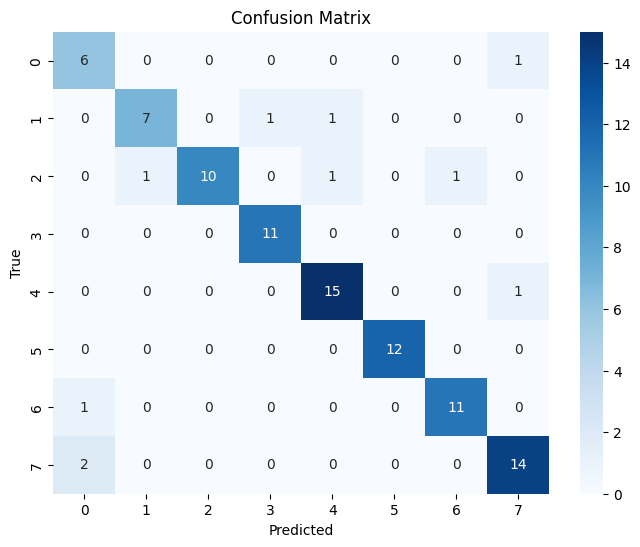

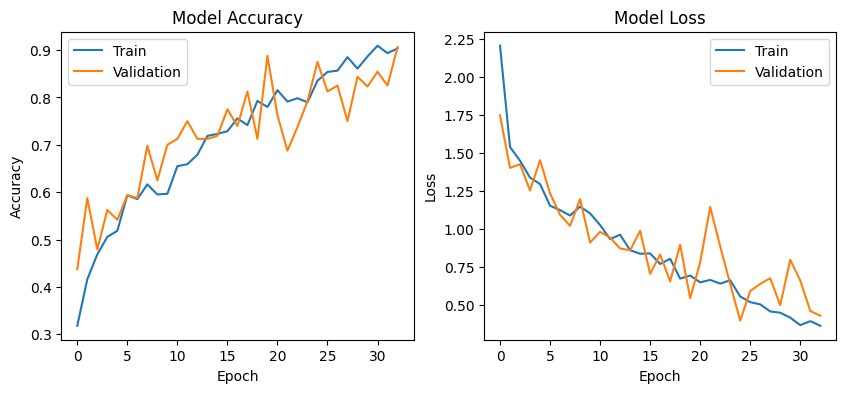

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

# Extract all images and labels from test_dataset
test_class_names = raw_training_dataset.class_names
labels = list(range(len(test_class_names)))
all_test_images = []
all_test_labels = []
for images, labels in test_dataset:
    all_test_images.append(images.numpy())
    all_test_labels.append(labels.numpy())

all_test_images = np.concatenate(all_test_images, axis=0)
all_test_labels = np.concatenate(all_test_labels, axis=0)

# Assign y_true from the extracted labels
y_true = all_test_labels

# Predict classes using the extracted images
y_pred_prob = model.predict(all_test_images)
y_pred = np.argmax(y_pred_prob, axis=1)

# 1. Classification report
print("=== CLASSIFICATION REPORT ===")
print(classification_report(
    y_true, y_pred,
    labels=labels
    target_names=test_class_names,
    output_dict=True,
    zero_division=0
    ))

# 2. Confusion Matrix
cm = confusion_matrix(
    y_true, y_pred
    labels=labels
    target_names=test_class_names,
    )

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_class_names,yticklabels=test_class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 3. Training Accuracy/Loss
plt.figure(figsize=(10, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])

plt.show()

# For ROC curve, you need a binary classification or a multi-class one-vs-rest approach
# Assuming it's a binary classification or a specific class vs rest for this line
# If it's multi-class, you might need to adapt this part.
# This line caused an error in previous run if there are more than 2 classes
# fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1]) # This assumes binary classification or a specific class.
# roc_auc = auc(fpr, tpr)

# plt.plot(fpr, tpr)
# plt.plot([0,1], [0,1], linestyle="--")
# plt.title(f"ROC Curve (AUC = {roc_auc:.3f})")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.show()

# df = panda.DataFrame(report).transpose()
# print(df)
# df.to_csv("precision_table.csv", index=True)

# Image classification with TensorFlow Lite Model Maker with TensorFlow 2.18.0

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/tutorials/model_maker_image_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/model_maker_image_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/model_maker_image_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/tutorials/model_maker_image_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook has been moved [here](https://www.tensorflow.org/lite/tutorials/model_maker_image_classification).

In [54]:

print(tf.__version__)

2.19.0


https://colab.research.google.com/github/TrainingBear/OPSI-Project-AndroidApplication/blob/master/tensorflow_examples/lite/model_maker/demo/image_classification.ipynb#scrollTo=w7AdazbUlvDJ